<a href="https://colab.research.google.com/github/mhdykz/colorQuantization/blob/ipynbFiles/Upgraded_DBscan_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#for image processing
from scipy.spatial import KDTree
# Importing KDTree for efficient neighbor search

In [44]:
image=Image.open('image.jpg')

In [45]:
image_array=np.array(image)
#creating a 2D numpy array where each element
#stores the intensity(how black or how white)
#of each pixel
# Convert to RGB if the image has an alpha channel
if image_array.shape[2] == 4:
    image_array = image_array[:, :, :3]  # Ignore the alpha channel
height, width, _ = image_array.shape
#image_array.shape returns a tuple


In [46]:
data = []
for x in range(width):
    for y in range(height):
        r, g, b = image_array[y, x][:3]
        data.append([x, y, r, g, b])
        #creating a list of pixel coordinates with
        #RGB values
data = np.array(data)
#turning the data list into a np array

In [47]:
class DBSCAN:
    def __init__(self, eps, min_samples):
        # Initialize the DBSCAN model with the given parameters.
        # eps: Maximum distance between two samples for them to be considered as in the same neighborhood.
        # min_samples: Minimum number of points required to form a dense region (cluster).
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None  # To store cluster labels for each data point

    def fit(self, data):
        coords = data[:, :2]  # Extracting x and y coordinates
        tree = KDTree(coords)  # Creating a KDTree for fast neighbor search
        labels = -1 * np.ones(data.shape[0], dtype=int)  # Initialize labels: -1 indicates unclassified points
        cluster_id = 0  # Initialize cluster ID counter
        total_points = data.shape[0]
        def get_neighbors(point_idx):
            point = coords[point_idx]  # Getting the coordinates of the current point
            indices = tree.query_ball_point(point, self.eps)  # Fast neighbor search using KDTree
            return indices  # Return the list of neighbors' indices

        def expand_cluster(point_idx, neighbors):
            labels[point_idx] = cluster_id  # Assign cluster ID to the core point
            i = 0
            while i < len(neighbors):
                neighbor_idx = neighbors[i]  # Get the index of the current neighbor point
                if labels[neighbor_idx] == -1:
                    labels[neighbor_idx] = cluster_id  # Assign cluster ID to noise points
                elif labels[neighbor_idx] == 0:
                    labels[neighbor_idx] = cluster_id  # Assign cluster ID to unvisited points
                    new_neighbors = get_neighbors(neighbor_idx)  # Get neighbors of the new point
                    if len(new_neighbors) >= self.min_samples:
                        neighbors.extend(new_neighbors)  # Add new neighbors to the list
                i += 1
        for i in range(len(data)):
            if i % 100 == 0:  # Print progress every 100 points
                print(f"Processing point {i}/{total_points}")
        for i in range(len(data)):
            if labels[i] == -1:
                neighbors = get_neighbors(i)  # Find neighbors for the current point
                if len(neighbors) >= self.min_samples:
                    cluster_id += 1  # Increment cluster ID for a new cluster
                    expand_cluster(i, neighbors)  # Expand the cluster from the current point

        self.labels_ = labels  # Store the final cluster labels
        return self  # Return the DBSCAN object for chaining!



In [48]:
dbscan=DBSCAN(eps=1,min_samples=1)
#instantiating the class
dbscan.fit(data)
#fitting the model on preprocessed image
labels=dbscan.labels_
#assigning labels into the variable
unique_labels=np.unique(labels)
#checking unique cluster IDs found
print(f"Number of clusters found(with noise):{len(unique_labels)}")


Processing point 0/22800
Processing point 100/22800
Processing point 200/22800
Processing point 300/22800
Processing point 400/22800
Processing point 500/22800
Processing point 600/22800
Processing point 700/22800
Processing point 800/22800
Processing point 900/22800
Processing point 1000/22800
Processing point 1100/22800
Processing point 1200/22800
Processing point 1300/22800
Processing point 1400/22800
Processing point 1500/22800
Processing point 1600/22800
Processing point 1700/22800
Processing point 1800/22800
Processing point 1900/22800
Processing point 2000/22800
Processing point 2100/22800
Processing point 2200/22800
Processing point 2300/22800
Processing point 2400/22800
Processing point 2500/22800
Processing point 2600/22800
Processing point 2700/22800
Processing point 2800/22800
Processing point 2900/22800
Processing point 3000/22800
Processing point 3100/22800
Processing point 3200/22800
Processing point 3300/22800
Processing point 3400/22800
Processing point 3500/22800
Proc

In [49]:
mean_colors = {}
for label in unique_labels:
    if label != -1:  # Ignore noise points
        cluster_points = data[labels == label]
        mean_color = np.mean(cluster_points[:, 2:], axis=0)  # Calculate mean RGB color
        mean_colors[label] = mean_color
for i in range(len(labels)):
    if labels[i] == -1:  # Noise point
        x, y = data[i, :2]
        _, nearest_idx = tree.query([x, y])
        nearest_label = labels[nearest_idx]
        if nearest_label != -1:
            labels[i] = nearest_label  # Assign the nearest cluster label to the noise point

# Recreate the image using the fixed labels
reconstructed_image = np.zeros_like(image_array)
for i, label in enumerate(labels):
    x, y = data[i, :2]
    if label == -1:
        reconstructed_image[int(y), int(x)] = [0, 0, 0]  # Assign any remaining noise to black
    else:
        reconstructed_image[int(y), int(x)] = mean_colors[label]


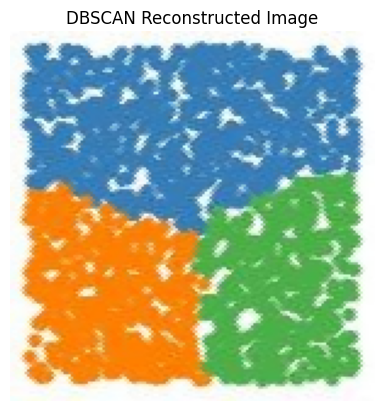

In [50]:
plt.imshow(reconstructed_image)
plt.title('DBSCAN Reconstructed Image')
plt.axis('off')  # Hide axis
plt.show()  # Render and display

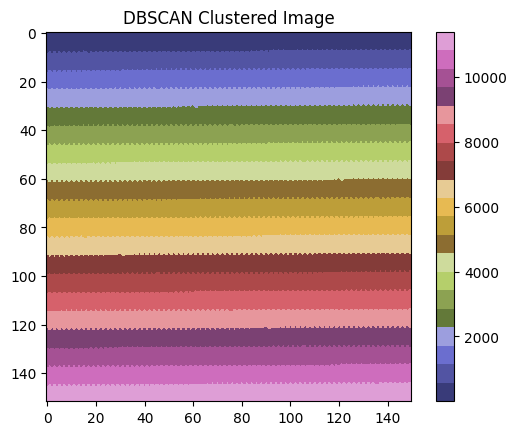

In [51]:
clustered_image=labels.reshape((height,width))
#reshape the 1D array back into a 2D array of dimenstions

plt.imshow(clustered_image,cmap='tab20b')
#displaying an image from a 2D array and using a colormap
plt.colorbar()
#adds colorbar to the side of our plot, which shows
#the mapping of colors to cluster labels and makes it easier to
#to identify which color corresponds to which cluster labels
plt.title('DBSCAN Clustered Image')
#adds title!
plt.show()
#render and display

#this will show us clusters and noise pixels(organizing the imageb)

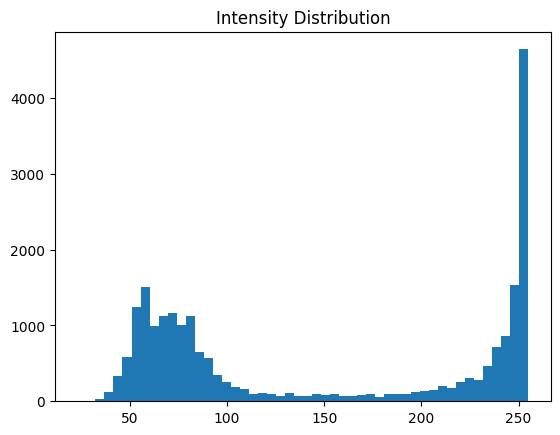

In [52]:
plt.hist(data[:, 2], bins=50)
plt.title('Intensity Distribution')
plt.show()

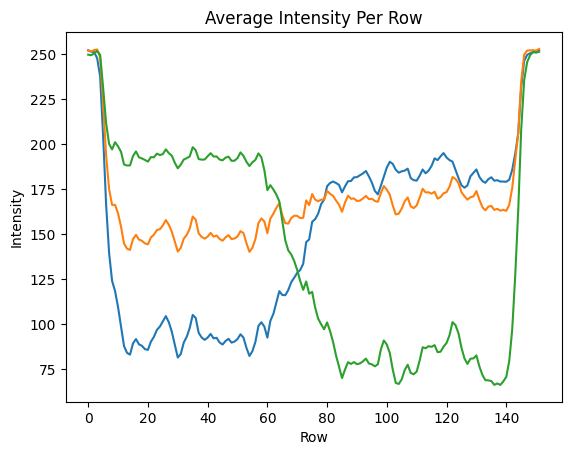

In [53]:
plt.plot(image_array.mean(axis=1))  # Average intensity per row
plt.title('Average Intensity Per Row')
plt.xlabel('Row')
plt.ylabel('Intensity')
plt.show()
